# Import libraries

In [315]:
# Basic data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [316]:
# Common model algorithms
from sklearn import linear_model, svm, tree, naive_bayes, ensemble
from xgboost import XGBRegressor

# Common model helpers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# Import Data

In [317]:
# my_data = pd.read_csv('data/train.csv')
my_data = pd.read_csv('data/train.csv')
my_data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,0.001567,-0.002716,-0.002616,0.001542,0.000444,0.001355,0.002986,-5.021082e-07,-0.003574,0.002277,...,T,-0.001178,0.001122,-0.002745,0.000074,-0.002104,-0.002863,-0.002665,0.000395,0.309301
1,-0.003053,0.002341,0.000214,-0.003934,0.000273,-0.003462,-0.001406,-2.909420e-03,0.003511,0.002110,...,W,0.003067,-0.000560,-0.002201,0.000443,0.002012,0.000383,0.001683,0.002143,0.423396
2,0.001435,0.001712,-0.000067,-0.002087,0.001251,-0.000157,-0.001618,1.684093e-03,-0.004051,0.000440,...,W,-0.000250,0.001027,0.003646,0.001145,-0.001239,0.003026,0.002528,0.001107,0.132837
3,0.001913,0.000249,-0.000782,0.000161,0.000719,0.000928,-0.000651,2.501691e-03,-0.002954,-0.001270,...,W,-0.000643,0.000905,-0.000038,-0.000178,0.000489,0.000936,0.000920,-0.000790,0.340411
4,-0.003259,0.005571,-0.000398,-0.003332,-0.000677,0.000233,0.000105,-1.540297e-04,0.000742,0.000997,...,W,0.002608,0.000794,0.002171,-0.000566,0.000077,0.000907,0.000204,0.000824,0.719293


In [318]:
print('Data dimension: {}'.format(my_data.shape))

Data dimension: (8000, 101)


# Data Cleaning

## Data Completeness

The goal of this step is to check if there are any missing values and to determine how to process missing values.

In [319]:
missing_rate = {}
for feature in my_data.columns:
    missing_rate[feature] = 100 * my_data[feature].isna().sum()/len(my_data[feature])
missing_rate_df = pd.DataFrame(list(missing_rate.values()), index=missing_rate.keys(), columns=['missing_rate'])
missing_rate_df['data_type'] = my_data.dtypes
missing_rate_df.head()

,missing_rate,data_type
x0,0.0000,float64
x1,0.0125,float64
x2,0.0000,float64
x3,0.0000,float64
x4,0.0000,float64


In [320]:
print('The maximum missing rate is {}%'.format(np.max(missing_rate_df['missing_rate'])))

The maximum missing rate is 0.05%


The **train.csv** has very low missing value rate. The maximum missing rate is 0.05%.

In [321]:
categorical_variables = list(missing_rate_df.loc[missing_rate_df.data_type == 'object',].index)
categorical_variables

quantitative_variables = list(set(my_data.columns) - set(categorical_variables) - set('y'))
quantitative_variables

print('Number of categorical variables: {}'.format(len(categorical_variables)))
print('Number of quantitative variables: {}'.format(len(quantitative_variables)))

Number of categorical variables: 3
Number of quantitative variables: 97


### Impute missing values

* For categorical variables, we fill the missing values with mode.
* For quantitative variables, we visualize the distribution with boxplots and see if the variable has too many outliers. If yes, we fill missing values with **median**. Otherwise, we use the **mean**.

**Barplots on categorical variables**

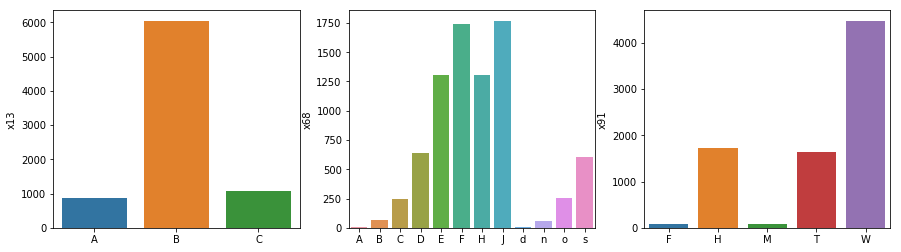

In [322]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i in range(len(categorical_variables)):
    f = categorical_variables[i]
    df = my_data[f].value_counts()
    df = df.sort_index()
    sns.barplot(df.index, df, ax=axs[i])

**Violinplots on quantitative variables**

In [323]:
my_data[sorted(my_data.columns)].head()

,x0,x1,x10,x11,x12,x13,x14,x15,x16,x17,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,0.001567,-0.002716,0.001166,-0.004272,0.001357,B,0.006459,0.001298,-0.001858,-0.003086,...,T,-0.001178,0.001122,-0.002745,0.000074,-0.002104,-0.002863,-0.002665,0.000395,0.309301
1,-0.003053,0.002341,0.000130,0.001720,-0.001639,B,0.001058,0.002080,-0.000407,0.003868,...,W,0.003067,-0.000560,-0.002201,0.000443,0.002012,0.000383,0.001683,0.002143,0.423396
2,0.001435,0.001712,-0.000184,-0.001161,-0.002717,B,-0.001738,0.000559,0.001972,-0.002340,...,W,-0.000250,0.001027,0.003646,0.001145,-0.001239,0.003026,0.002528,0.001107,0.132837
3,0.001913,0.000249,-0.001493,0.001849,-0.001108,B,0.001223,0.000116,-0.001404,-0.000106,...,W,-0.000643,0.000905,-0.000038,-0.000178,0.000489,0.000936,0.000920,-0.000790,0.340411
4,-0.003259,0.005571,0.000829,0.001113,-0.003479,B,-0.001870,-0.001670,0.000835,-0.000406,...,W,0.002608,0.000794,0.002171,-0.000566,0.000077,0.000907,0.000204,0.000824,0.719293


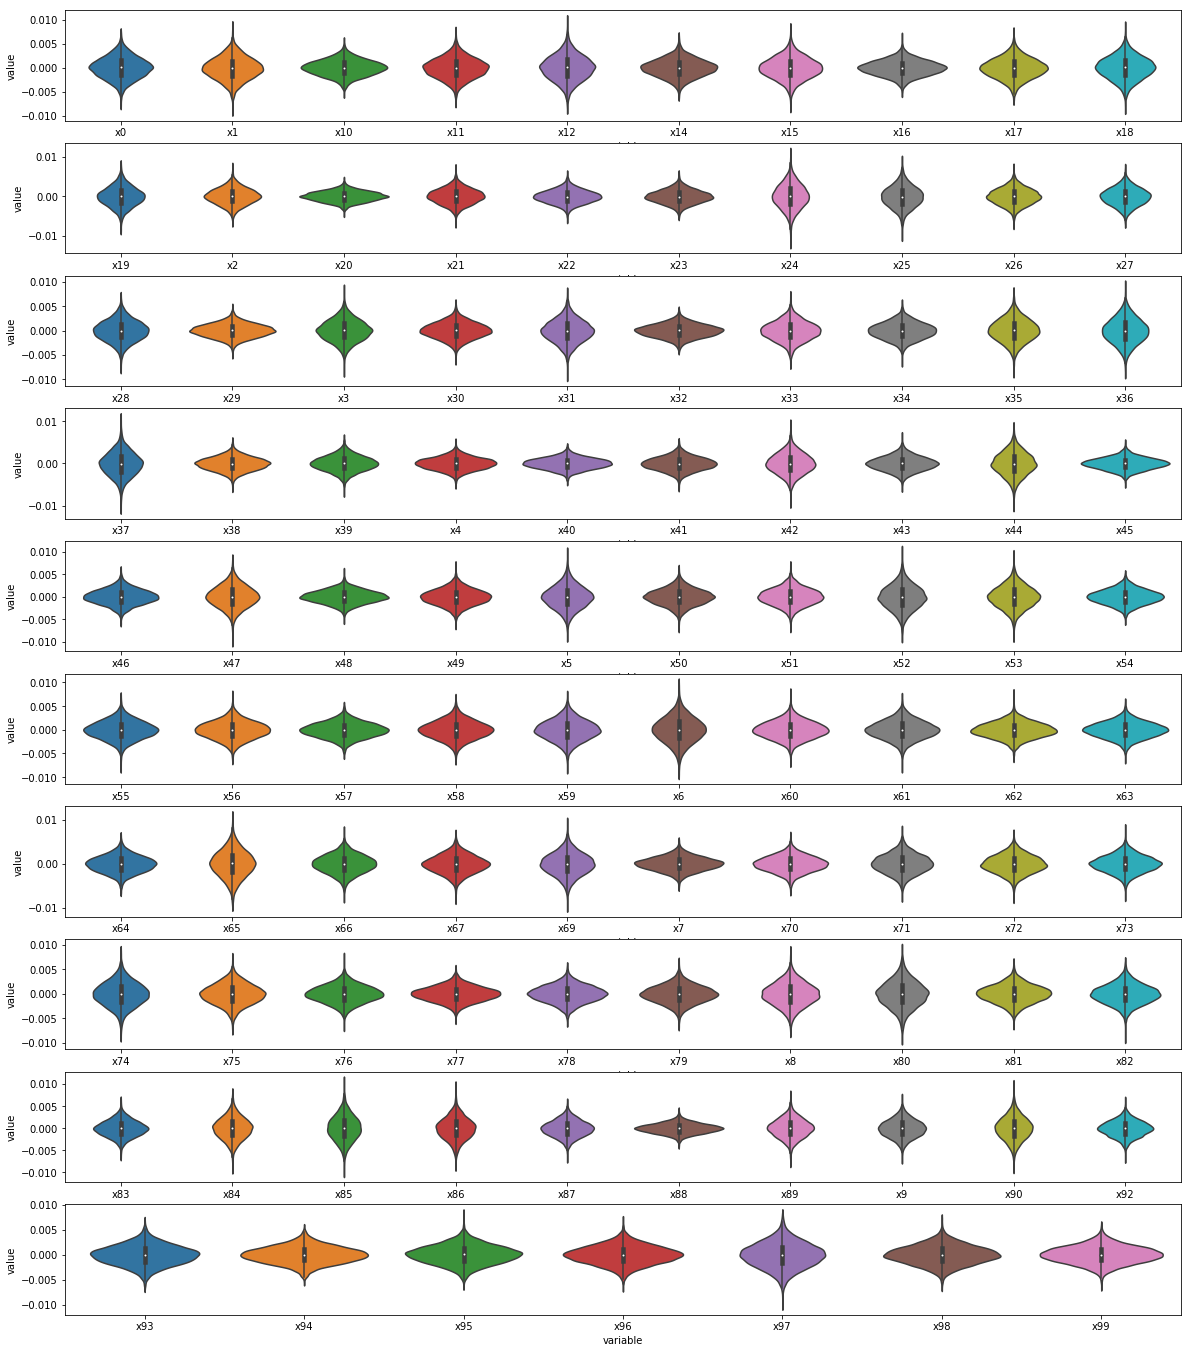

In [324]:
quantitative_variables = sorted(quantitative_variables)
fig, axs = plt.subplots(10, 1, figsize=(20,24)) 
for i in range(10):
    cols = quantitative_variables[i*10:(i+1)*10]
    if i == 9:
        cols = quantitative_variables[i*10:]
    df = my_data[cols]
    sns.violinplot(x="variable", y="value", data=df.melt(), ax=axs[i])

<span style="color:red">**Useful information from this step**</span>

+ The violinplots show that almost all quantitative variables have pretty much symmetric distribution with some extreme values. Both median and mean would be a good value for filling missing values.

In [325]:
# fill missing values in quantitative variables with median
for x in quantitative_variables:
    my_data[x].fillna(my_data[x].median(), inplace=True)
    
# fill missing values in categorical variables with mode
for x in categorical_variables:
    my_data[x].fillna(my_data[x].mode()[0], inplace=True)

Recheck the completeness of the data.

In [326]:
for x in my_data.columns:
    off = True
    missing_rate = my_data[x].isnull().sum()/my_data.shape[0]
    if  missing_rate != 0:
        print('{:<10} {}%'.format(x, missing_rate))
if off:
    print('Good. No variable has missing value!')

Good. No variable has missing value!


# Exploratory Data Analysis

Let's check the correlation among explanatory variables.

In [327]:
quant_corr_matrix = my_data[quantitative_variables].corr()

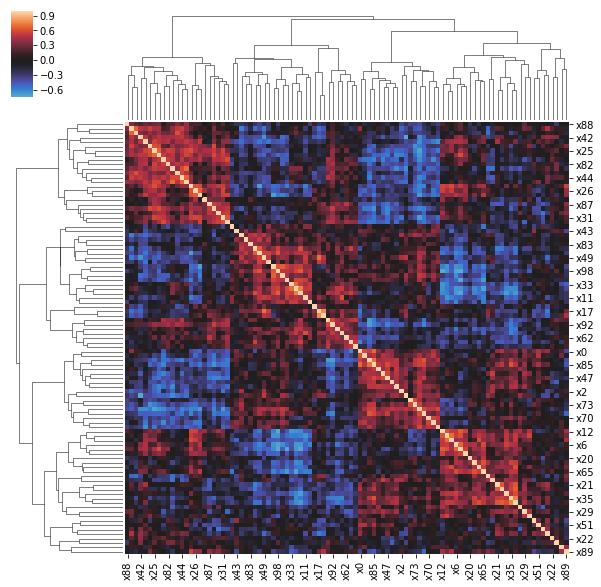

In [328]:
sns.clustermap(quant_corr_matrix, center=0)
plt.show()

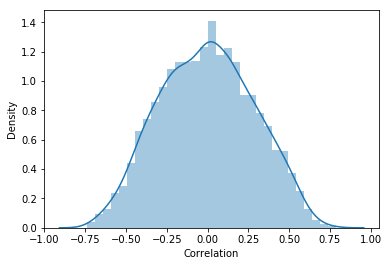

In [329]:
# Plot the density of correlation coefficients
corrs = np.array(quant_corr_matrix)[np.triu_indices(97, 1)]
sns.distplot(corrs)
ax = plt.gca()
ax.set_xlabel('Correlation')
ax.set_ylabel('Density')
plt.show()

<span style="color:red">**Useful information from this step**</span>

+ The cluster heatmap shows which explanatory variables are correlated and to what extend they are correlated. 
+ The density plot shows the distribution of correlation coefficients.
+ These two plots indicate that the majority of coefficient values are between (-0.5, 0.5), which means the correlation among explanatory variables are not very strong. This is good for modeling the data. 

## Check relationship between explanatory variables and the target variable


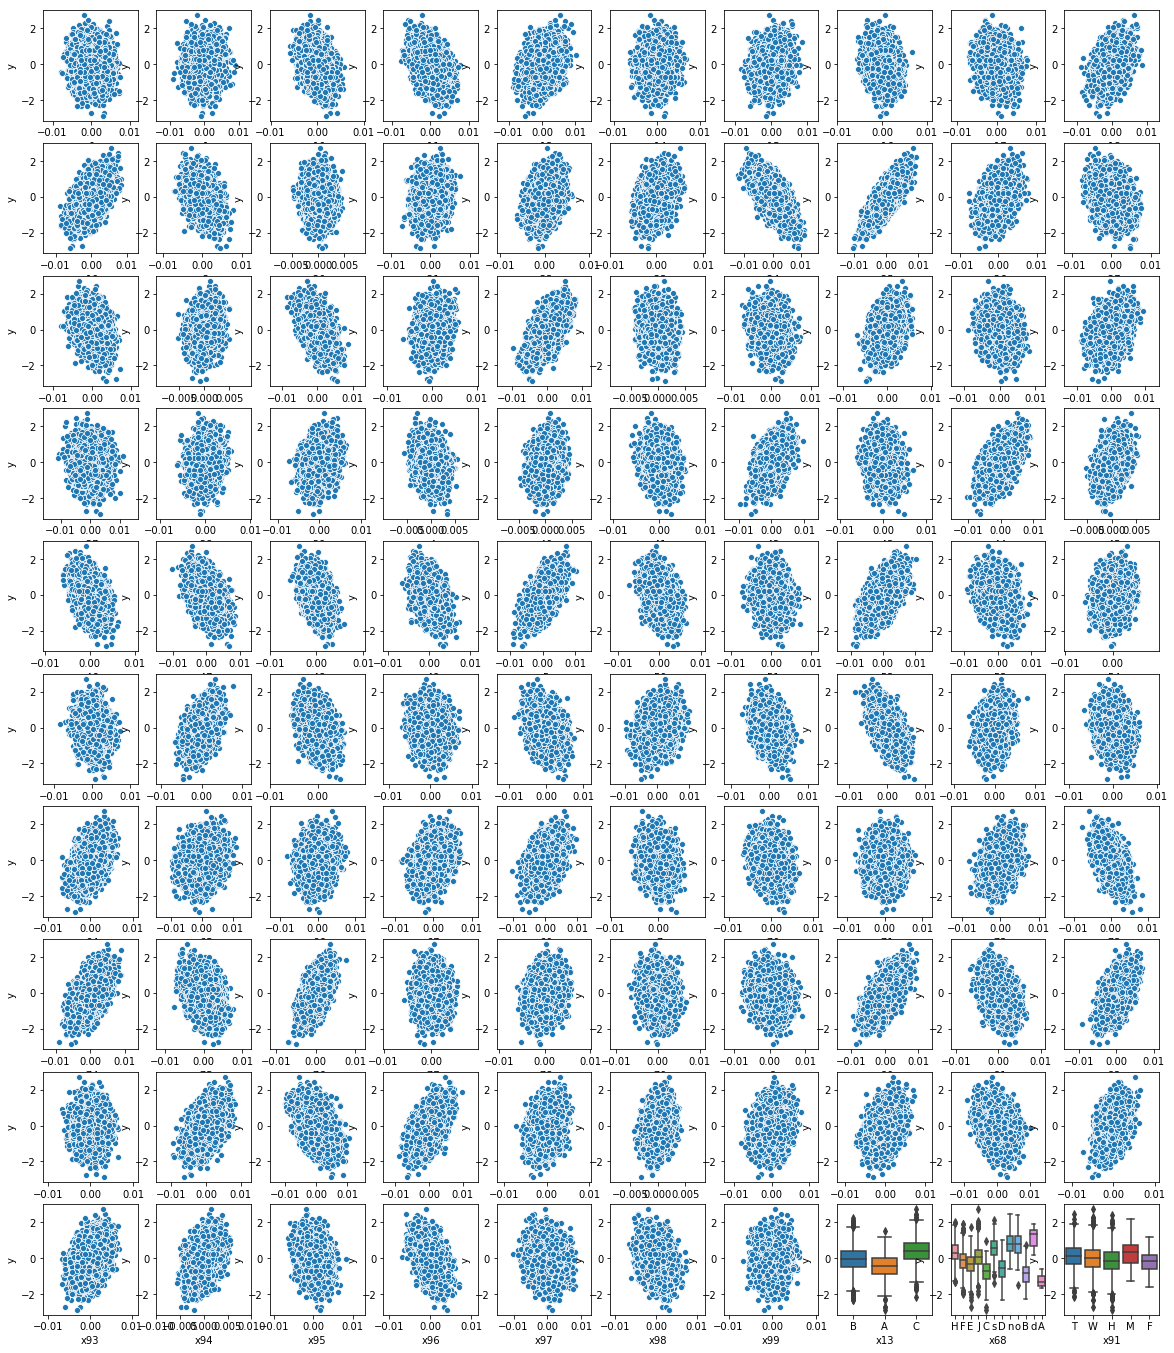

In [330]:
quantitative_variables = sorted(quantitative_variables)
fig, axs = plt.subplots(10, 10, figsize=(20, 24)) 
for i in range(len(quantitative_variables)):
    row_index = i // 10
    col_index = i % 10
    f = quantitative_variables[i]
    df = my_data[[f, 'y']]
    sns.scatterplot(x=f, y="y", data=df, ax=axs[row_index][col_index])
sns.boxplot(x="x13", y="y", data=my_data[["x13", "y"]], ax=axs[9][7])
sns.boxplot(x="x68", y="y", data=my_data[["x68", "y"]], ax=axs[9][8])
sns.boxplot(x="x91", y="y", data=my_data[["x91", "y"]], ax=axs[9][9])

<span style="color:red">**Useful information from this step**</span>

+ There are 97 quantitative explanatory variables. Most of them have a **linear relationship** with the target variable at different levels.
+ The target variable is affected by the categorical variables "x13" and "x68". However, "x91" has very weak influence on the target variable.
+ **Didn't find any non-linear pattern between explanatory variable and target variable. Which means that a multivariate linear regression model might be enough to model the data.**

# Initial round of data modeling

The purpose of the step is to model the data with a set of regression algorithms, from simple linear regression to more advanced ensembling methods. After finding a couple of models that best describe the data, model tuning and selection approaches are applied to find the best model.

## Convert format

Dummy encode categorical data.

In [331]:
# one hot encode categorical variables
my_data_dummy_variables = pd.get_dummies(my_data[categorical_variables])

# drop original categorical variables and replace them with dummy encoded variables.
my_data.drop(categorical_variables, axis=1, inplace=True)
my_data = pd.concat([my_data_dummy_variables, my_data], axis=1)

In [332]:
Y = my_data.y
my_data.drop('y', axis=1, inplace=True)

## Initial machine learning algorithms

In [333]:
MLA = [
    # GLM
    linear_model.LinearRegression(),
    linear_model.Ridge(alpha=0.1),
    linear_model.Lasso(alpha=0.1),
    linear_model.ElasticNet(alpha=0.1),
    
    # Trees
    tree.DecisionTreeRegressor(),
    
    # SVM 
    svm.LinearSVR(),
    svm.NuSVR(),
    svm.SVR(),
    
    # Ensemble Methods
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    
    # xgboost
    XGBRegressor()
    
]

# run 10x cross validation


## Split data into train/test and run cross-validation

In [334]:
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)

## Train model and make predictions

In [335]:
# create table to store MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Score Mean', 
               'MLA Test Score Mean','MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predictions = pd.DataFrame({'Y': Y})

X = my_data
Y = np.array(Y)
row_index = 0
for alg in MLA:
    
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # train model
    cv_results = model_selection.cross_validate(alg, X, Y, cv=cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Score Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Score Mean'] = cv_results['test_score'].mean()
    
    # save MLA predictions
    alg.fit(X, Y)
    MLA_predictions[MLA_name] = alg.predict(X)
    
    row_index+=1

## Performance comparison

In [336]:
MLA_compare.sort_values(by = ['MLA Test Score Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Score Mean,MLA Test Score Mean,MLA Time
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.999824,0.999806,0.0589204
8,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",0.940644,0.908014,4.20265
10,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.940446,0.907507,3.05863
9,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.963902,0.810103,2.60582
1,Ridge,"{'alpha': 0.1, 'copy_X': True, 'fit_intercept'...",0.776375,0.772978,0.0139102
4,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': None, 'max_f...",1,0.590032,0.455014
5,LinearSVR,"{'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_...",0.529942,0.521442,0.10134
7,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.317981,0.307981,2.73265
6,NuSVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.313971,0.304705,2.16693
3,ElasticNet,"{'alpha': 0.1, 'copy_X': True, 'fit_intercept'...",0.0148837,0.0136742,0.0161933


In [338]:
MLA_predictions.head()

,Y,LinearRegression,Ridge,Lasso,ElasticNet,DecisionTreeRegressor,LinearSVR,NuSVR,SVR,GradientBoostingRegressor,RandomForestRegressor,XGBRegressor
0,0.309301,0.309532,0.345081,-0.015739,-0.004800,0.309301,0.296089,0.265682,0.271405,0.522259,0.394122,0.536463
1,0.423396,0.435753,0.116193,-0.015739,-0.020861,0.423396,-0.027654,-0.132649,-0.116786,0.382530,0.281333,0.391888
2,0.132837,0.135635,0.100133,-0.015739,-0.034974,0.132837,-0.097178,-0.305042,-0.307351,0.368515,0.199840,0.367025
3,0.340411,0.344864,0.042939,-0.015739,-0.020861,0.340411,0.024480,0.041196,0.053437,0.112621,0.316110,0.117353
4,0.719293,0.734451,0.336158,-0.015739,-0.020861,0.719293,0.124953,-0.129735,-0.113197,0.581414,0.534971,0.541740


<span style="color:red">**Useful information from this step**</span>

The results show that the linear regression algorithm has the best performance on both the train and test data. The second high performance scores come from the Gradient Boosting Regression algorithm, which is a tree based algorithm. The next step is to focus on these two models and find the best linear regression model and a best tree model. 

# Final Model Selection

## Linear Model Selection

Common linear model selection methods include stepwise (forward, backward) selection, best subset selection, and regularization. There are 100 features, exhaustively searching the best model with the best subset selection method is very time-consuming. In this project, a stepwise (forward, backward) selection method would be enough.

<span style="color:red">**Since R has existing packages that can do stepwise model selection more efficiently, I will perform my analysis in R for this part.**</span>